<a href="https://colab.research.google.com/github/ciphenseadmin/partial-face-recognition/blob/master/Mask_Overlay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install face_recognition

In [0]:
import os
import sys
import random
import argparse
import numpy as np
from PIL import Image, ImageFile

__version__ = '0.3.0'


IMAGE_DIR = '/content/drive/My Drive/images'
DEFAULT_IMAGE_PATH = os.path.join(IMAGE_DIR, 'default-mask.png')
BLACK_IMAGE_PATH = os.path.join(IMAGE_DIR, 'black-mask.png')
BLUE_IMAGE_PATH = os.path.join(IMAGE_DIR, 'blue-mask.png')
RED_IMAGE_PATH = os.path.join(IMAGE_DIR, 'red-mask.png')


def cli():
    parser = argparse.ArgumentParser(description='Wear a face mask in the given picture.')
    parser.add_argument('pic_path', help='Picture path.')
    parser.add_argument('--show', action='store_true', help='Whether show picture with mask or not.')
    parser.add_argument('--model', default='hog', choices=['hog', 'cnn'], help='Which face detection model to use.')
    group = parser.add_mutually_exclusive_group()
    group.add_argument('--black', action='store_true', help='Wear black mask')
    group.add_argument('--blue', action='store_true', help='Wear blue mask')
    group.add_argument('--red', action='store_true', help='Wear red mask')
    args = parser.parse_args()

    pic_path = args.pic_path
    if not os.path.exists(args.pic_path):
        print(f'Picture {pic_path} not exists.')
        sys.exit(1)

    if args.black:
        mask_path = BLACK_IMAGE_PATH
    elif args.blue:
        mask_path = BLUE_IMAGE_PATH
    elif args.red:
        mask_path = RED_IMAGE_PATH
    else:
        mask_path = DEFAULT_IMAGE_PATH

    FaceMasker(pic_path, mask_path, args.show, args.model).mask()


def create_mask(image_path):
    pic_path = image_path
    blue_mask = "blue-mask.png"
    white_mask = "default-mask.png"
    if(np.random.randint(0,2) ==0):
        mask_path = "/content/drive/My Drive/images/" + blue_mask
    else:
        mask_path = "/content/drive/My Drive/images/" + white_mask
    show = False
    model = "hog"
    FaceMasker(pic_path, mask_path, show, model).mask()

not_found_faces = []

class FaceMasker:
    KEY_FACIAL_FEATURES = ('nose_bridge', 'chin')

    def __init__(self, face_path, mask_path, show=True, model='hog'):
        self.face_path = face_path
        self.mask_path = mask_path
        self.show = show
        self.model = model
        self._face_img: ImageFile = None
        self._mask_img: ImageFile = None
     

    def mask(self):
        import face_recognition

        face_image_np = face_recognition.load_image_file(self.face_path)
        face_locations = face_recognition.face_locations(face_image_np, model=self.model)
        face_landmarks = face_recognition.face_landmarks(face_image_np, face_locations)
        self._face_img = Image.fromarray(face_image_np)
        self._mask_img = Image.open(self.mask_path)

        found_face = False
        for face_landmark in face_landmarks:
            # check whether facial features meet requirement
            skip = False
            for facial_feature in self.KEY_FACIAL_FEATURES:
                if facial_feature not in face_landmark:
                    skip = True
                    break
            if skip:
                continue

            # mask face
            found_face = True
            self._mask_face(face_landmark)

        if found_face:
            self._save()

        else:
            not_found_faces.append(self.face_path)
            print('Found no face.')

    def _mask_face(self, face_landmark: dict):
        nose_bridge = face_landmark['nose_bridge']
        nose_point = nose_bridge[len(nose_bridge) * 1 // 4]
        nose_v = np.array(nose_point)

        chin = face_landmark['chin']
        chin_len = len(chin)
        chin_bottom_point = chin[chin_len // 2]
        chin_bottom_v = np.array(chin_bottom_point)
        chin_left_point = chin[chin_len // 8]
        chin_right_point = chin[chin_len * 7 // 8]

        # split mask and resize
        width = self._mask_img.width
        height = self._mask_img.height
        width_ratio = 1.2
        new_height = int(np.linalg.norm(nose_v - chin_bottom_v))

        # left
        mask_left_img = self._mask_img.crop((0, 0, width // 2, height))
        mask_left_width = self.get_distance_from_point_to_line(chin_left_point, nose_point, chin_bottom_point)
        mask_left_width = int(mask_left_width * width_ratio)
        mask_left_img = mask_left_img.resize((mask_left_width, new_height))

        # right
        mask_right_img = self._mask_img.crop((width // 2, 0, width, height))
        mask_right_width = self.get_distance_from_point_to_line(chin_right_point, nose_point, chin_bottom_point)
        mask_right_width = int(mask_right_width * width_ratio)
        mask_right_img = mask_right_img.resize((mask_right_width, new_height))

        # merge mask
        size = (mask_left_img.width + mask_right_img.width, new_height)
        mask_img = Image.new('RGBA', size)
        mask_img.paste(mask_left_img, (0, 0), mask_left_img)
        mask_img.paste(mask_right_img, (mask_left_img.width, 0), mask_right_img)

        # rotate mask
        angle = np.arctan2(chin_bottom_point[1] - nose_point[1], chin_bottom_point[0] - nose_point[0])
        rotated_mask_img = mask_img.rotate(angle, expand=True)

        # calculate mask location
        center_x = (nose_point[0] + chin_bottom_point[0]) // 2
        center_y = (nose_point[1] + chin_bottom_point[1]) // 2

        offset = mask_img.width // 2 - mask_left_img.width
        radian = angle * np.pi / 180
        box_x = center_x + int(offset * np.cos(radian)) - rotated_mask_img.width // 2
        box_y = center_y + int(offset * np.sin(radian)) - rotated_mask_img.height // 2

        # add mask
        self._face_img.paste(mask_img, (box_x, box_y), mask_img)

    def _save(self):
        path_splits = os.path.splitext(self.face_path)
        new_face_path = self.face_path
        self._face_img.save(new_face_path)
        print(f'Save to {new_face_path}')

    @staticmethod
    def get_distance_from_point_to_line(point, line_point1, line_point2):
        distance = np.abs((line_point2[1] - line_point1[1]) * point[0] +
                          (line_point1[0] - line_point2[0]) * point[1] +
                          (line_point2[0] - line_point1[0]) * line_point1[1] +
                          (line_point1[1] - line_point2[1]) * line_point1[0]) / \
                   np.sqrt((line_point2[1] - line_point1[1]) * (line_point2[1] - line_point1[1]) +
                           (line_point1[0] - line_point2[0]) * (line_point1[0] - line_point2[0]))
        return int(distance)


In [0]:
!pip install mtcnn
import mtcnn
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # opencv
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image
import os
# !pip install face_recognition
import face_recognition

def extract_face_1(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    face_image_np = face_recognition.load_image_file(filename)
    face_locations = face_recognition.face_locations(face_image_np, model='hog')
    print(face_locations)  
    face_landmarks = face_recognition.face_landmarks(face_image_np, face_locations)
    
    _face_img = Image.fromarray(face_image_np)
    # extract the bounding box from the first face
    # x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    # top,right,bottom,left
    # ____________________
    # |                   |
    # |                   |
    # |                   |
    # |___________________|
    y1,x2,y2,x1 = face_locations[0]
    _, y2= face_landmarks[0]['chin'][len(face_landmarks[0]['chin'])//2]
    # chin = face_lan
    # extract the face
    face = pixels[y1:(y2), x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    # print(image)
    face_array = np.asarray(image)
    return face_array

def extract_face_2(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    print(results)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1) 
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    # print(image)
    face_array = np.asarray(image)
    return face_array

In [0]:
import os
root_folder_path = "/content/drive/My Drive/val_1"
list_folder_paths = [os.path.join(root_folder_path, f) for f in os.listdir(root_folder_path) if os.path.isdir(os.path.join(root_folder_path, f))]
# print(len(list_folder_paths))

count = 0
d = 0
for index,folder in enumerate(list_folder_paths):
    print(index,folder)
    images = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    for i in range(len(images)):
        print("the path of the image is", images[i])
        count+=1
        try:
            count+=1
            a = extract_face_1(images[i])
            plt.imsave(images[i],a)
            create_mask(images[i])
        except:
            try:
                count+=1
                a = extract_face_2(images[i])
                plt.imsave(images[i],a)
                create_mask(images[i])
            except:
                pass  

0 /content/drive/My Drive/val_1/Angelina_Jolie
the path of the image is /content/drive/My Drive/val_1/Angelina_Jolie/Angelina_Jolie_0007.jpg
the path of the image is /content/drive/My Drive/val_1/Angelina_Jolie/Angelina_Jolie_0018.jpg
the path of the image is /content/drive/My Drive/val_1/Angelina_Jolie/Angelina_Jolie_0020.jpg
the path of the image is /content/drive/My Drive/val_1/Angelina_Jolie/Angelina_Jolie_0012.jpg
the path of the image is /content/drive/My Drive/val_1/Angelina_Jolie/Angelina_Jolie_0006.jpg
the path of the image is /content/drive/My Drive/val_1/Angelina_Jolie/Angelina_Jolie_0011.jpg
1 /content/drive/My Drive/val_1/Anna_Kournikova
the path of the image is /content/drive/My Drive/val_1/Anna_Kournikova/Anna_Kournikova_0003.jpg
the path of the image is /content/drive/My Drive/val_1/Anna_Kournikova/Anna_Kournikova_0006.jpg
the path of the image is /content/drive/My Drive/val_1/Anna_Kournikova/Anna_Kournikova_0009.jpg
the path of the image is /content/drive/My Drive/val_

In [0]:
print(count)

1542


In [0]:
!pip install mtcnn
import mtcnn
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # opencv
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image
import os





Using TensorFlow backend.


[{'box': [75, 70, 93, 122], 'confidence': 0.9999803304672241, 'keypoints': {'left_eye': (109, 115), 'right_eye': (151, 123), 'nose': (130, 135), 'mouth_left': (106, 159), 'mouth_right': (140, 167)}}]


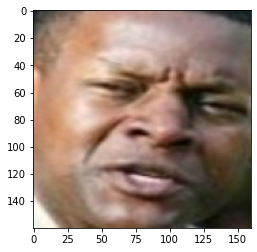

In [0]:
a = extract_face('/content/drive/My Drive/val/Charles_Moose/Charles_Moose_0006.jpg')
plt.imshow(a)

In [0]:
root_folder_path = "/content/drive/My Drive/val"
list_folder_paths = [os.path.join(root_folder_path, f) for f in os.listdir(root_folder_path) if os.path.isdir(os.path.join(root_folder_path, f))]
# print(len(list_folder_paths))
for index,folder in enumerate(list_folder_paths):
    print(index,folder)
    images = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    for i in range(len(images)):
        print("the path of the image is", images[i])
        a = extract_face(images[i])
        plt.imsave(images[i],a)
        create_mask(images[i])

0 /content/drive/My Drive/val/Cesar_Gaviria
the path of the image is /content/drive/My Drive/val/Cesar_Gaviria/Cesar_Gaviria_0007.jpg
Save to /content/drive/My Drive/val/Cesar_Gaviria/Cesar_Gaviria_0007.jpg
the path of the image is /content/drive/My Drive/val/Cesar_Gaviria/Cesar_Gaviria_0006.jpg
Save to /content/drive/My Drive/val/Cesar_Gaviria/Cesar_Gaviria_0006.jpg
the path of the image is /content/drive/My Drive/val/Cesar_Gaviria/Cesar_Gaviria_0005.jpg
Save to /content/drive/My Drive/val/Cesar_Gaviria/Cesar_Gaviria_0005.jpg
1 /content/drive/My Drive/val/Charles_Moose
the path of the image is /content/drive/My Drive/val/Charles_Moose/Charles_Moose_0006.jpg
Found no face.
the path of the image is /content/drive/My Drive/val/Charles_Moose/Charles_Moose_0010.jpg
Save to /content/drive/My Drive/val/Charles_Moose/Charles_Moose_0010.jpg
the path of the image is /content/drive/My Drive/val/Charles_Moose/Charles_Moose_0013.jpg
Save to /content/drive/My Drive/val/Charles_Moose/Charles_Moose_0

In [0]:
all_files = not_found_faces

In [0]:
print(len(all_files))

36
